In [1]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

# Loading base images and coverting them to grayscale
face = cv2.imread("obama.jpg")
body = cv2.imread("trump.jpeg")

face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
body_gray = cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)

# Create empty matrices in the images' shapes
height, width = face_gray.shape
mask = np.zeros((height, width), np.uint8)

height, width, channels = body.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

In [2]:
# Loading models and predictors of the dlib library to detect landmarks in both faces
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

# Getting landmarks for the face that will be swapped into to the body
rect = detector(face_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks = predictor(face_gray, rect)
landmarks_points = [] 

def get_landmarks(landmarks, landmarks_points):
  for n in range(68):
      x = landmarks.part(n).x
      y = landmarks.part(n).y
      landmarks_points.append((x, y))

get_landmarks(landmarks, landmarks_points)

points = np.array(landmarks_points, np.int32)


The Convex Hull of a shape or a group of points is a tight fitting convex boundary around the points or the shape, we are using this to generate a mask around the landmark point over the subject's face.

https://www.learnopencv.com/convex-hull-using-opencv-in-python-and-c/

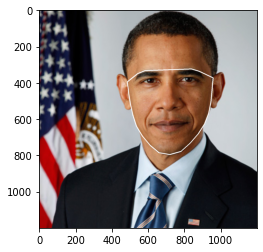

In [3]:
convexhull = cv2.convexHull(points) 

face_cp = face.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(face_cp, [convexhull], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

face_image_1 = cv2.bitwise_and(face, face, mask=mask)

Now we can divide the faces in triangles using the landmarks. The triangles will be used to fit the facial features of the first person in the second one's face, this is important because each person's face is shaped diferently and the photos can be taken from different perspectives.
https://www.learnopencv.com/delaunay-triangulation-and-voronoi-diagram-using-opencv-c-python/

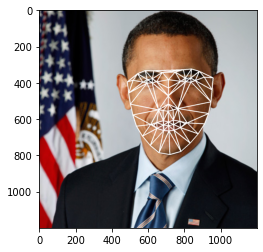

In [4]:
rect = cv2.boundingRect(convexhull)

subdiv = cv2.Subdiv2D(rect) # Creates an instance of Subdiv2D
subdiv.insert(landmarks_points) # Insert points into subdiv
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

indexes_triangles = []
face_cp = face.copy()


def get_index(arr):
    index = 0
    if arr[0]:
        index = arr[0][0]
    return index

for triangle in triangles :

    # Gets the vertex of the triangle
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])
    
    # Draws a line for each side of the triangle
    cv2.line(face_cp, pt1, pt2, (255, 255, 255), 3,  0)
    cv2.line(face_cp, pt2, pt3, (255, 255, 255), 3,  0)
    cv2.line(face_cp, pt3, pt1, (255, 255, 255), 3,  0)

    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = get_index(index_pt1)
    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = get_index(index_pt2)
    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = get_index(index_pt3)

    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        vertex = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(vertex)

# Draw delaunay triangles
plt.imshow(cv2.cvtColor(face_cp, cv2.COLOR_BGR2RGB))   


In [8]:
face_gray.shape

(1200, 1200)

In [9]:
# https://www.pyimagesearch.com/2019/12/16/training-a-custom-dlib-shape-predictor/